In [254]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [255]:
%run init.py

Current time: 2020-04-09 18:46:31.709037


In [256]:
#############################################
# Read data from github repo: https://github.com/pcm-dpc/COVID-19
# Dipartimento della Protezione Civile
#############################################
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv'
prov = pd.read_csv(url)

# Province #################
prov = prov.rename(columns={
    'data': 'date',
    'totale_casi': 'cases',
    'denominazione_provincia': 'provincia',
    'denominazione_regione': 'region'
})
prov['date'] = prov['date'].map(lambda date: datetime.datetime.strptime(date, '%Y-%m-%dT%H:%M:%S'))
prov = prov.sort_values(['provincia', 'date', 'region'])

# remove "In fase di definizione/aggiornamento" rows
prov = prov[~prov.provincia.str.contains("In fase di definizione/aggiornamento")]

#add differential data
prov['new_cases'] = prov['cases'].diff()

# add tassi d'incremento
def delta(data, variables):
    '''Tasso di crescita mediato sugli ultimi 1,2,3,4 giorni'''
    for var in variables: 
        for dayspan in [1,2,3,4]:
            colname = var+'_delta'+str(dayspan)
            data[colname] = 0
            for i in np.arange(dayspan):
                data[colname] = data[colname] + data['new_'+var].shift(i)/data[var].shift(i+1)
            data[colname] = data[colname]/dayspan    
    return data
prov = delta(prov, ['cases'])
 
# Popolazione provinciale ###############
population_prov = {
    # sicilia
    'Enna': 164788,
    'Catania': 1107702,
    'Caltanissetta': 262458,
    'Palermo': 1252588,
    'Messina': 626876,
    'Agrigento': 434870,
    'Siracusa': 399224,
    'Ragusa': 320893,
    'Trapani': 430492,

    #'Bologna': 1e6,
    #'Bergamo': 1.11e6,
    #'Brescia': 1.26e6,
    #'Milano': 3.26e6,
    #'Rimini': 335e3,
    #'Roma': 4.35e6,
    #'Napoli': 3.12e6
}
# add population information
for provincia in population_prov.keys():
    prov.at[prov.provincia==provincia, 'population'] = population_prov[provincia]
prov['population'] = prov['population'].replace(np.nan, 9999999999)

# add data per 100k inhabitants
for var in ['cases','new_cases']:
    prov[var+'_per100k'] = prov.apply(lambda row: row[var]/row.population*1e5, axis = 1)

prov['population'] = prov['population'].replace(9999999999, np.nan)

#store dataframe
prov.to_pickle('dataframes/mydata_dpc_ita_province.p')


# Utility functions ###############
def sorted_set_prov(df, province, var):
    '''Ordina set rispetto alla variabile var'''
    df = df[df.provincia.isin(province)][df.date==lastday].sort_values(var, ascending=False)
    sortedset = df.provincia.unique()
    return sortedset

In [257]:
# retrieve national and regional data
ita = pd.read_pickle('dataframes/mydata_dpc_ita.p')

# Tabella Dati Provinciali

In [258]:
lastday = prov.date.iat[-1]
print('Dati aggiornati a:', lastday)

summary = prov[prov.date==lastday].sort_values('cases', ascending=False)
summary = summary[['provincia','region','cases','new_cases','population','cases_per100k']]
summary = summary.reset_index(drop=True)
summary.head(30)

Dati aggiornati a: 2020-04-09 17:00:00


,provincia,region,cases,new_cases,population,cases_per100k
0,Milano,Lombardia,12479,440.0,NaN,0.12479
1,Brescia,Lombardia,10122,213.0,NaN,0.10122
2,Bergamo,Lombardia,10043,112.0,NaN,0.10043
3,Torino,Piemonte,6925,330.0,NaN,0.06925
4,Cremona,Lombardia,4489,67.0,NaN,0.04489
5,Reggio nell'Emilia,Emilia-Romagna,3505,153.0,NaN,0.03505
6,Monza e della Brianza,Lombardia,3355,91.0,NaN,0.03355
7,Padova,Veneto,3134,78.0,NaN,0.03134
8,Verona,Veneto,3049,129.0,NaN,0.03049
9,Roma,Lazio,3026,116.0,NaN,0.03026


In [259]:
def standing_normalized(province, region_header, var, title='', xlabel='x', xmax=100):

    n = len(province)*0.1
    
    fig = plt.figure(figsize=(12,6*n))
    ax = fig.add_subplot(111)
    
    province = sorted_set_prov(prov, province, 'cases_per100k')
    province = province[::-1]
    
    for i,provincia in enumerate(province):
        df = prov[prov.provincia==provincia]
        tot = df[var].iat[-1]
        ax.barh(provincia, df[var+'_per100k'].iat[-1], label='')
        lb = '%d (+%.f)' % (tot, df['new_'+var].iat[-1])
        ax.text(df[var+'_per100k'].iat[-1]+2, provincia, lb, ha='left', va='center', fontsize=14)
        
    if region_header!=None:
        df = ita[ita.region==region_header]
        tot = df[var].iat[-1]
        ax.barh(region_header, df[var+'_per100k'].iat[-1], label='', color='white', edgecolor='black', lw=3)
        lb = '%d (+%.f)' % (tot, df['new_'+var].iat[-1])
        ax.text(df[var+'_per100k'].iat[-1]+2, region_header, lb, ha='left', va='center', fontsize=14)
    
    plt.xlabel(xlabel)
    ax.grid(axis='x', linewidth=2, alpha=0.1, which='major')
    ax.tick_params(axis='x', which='major', labelsize=16)
    ax.set_xlim(0,xmax)
    
    #legend
    plt.title(title+' (%s)' % lastday.strftime('%-d %b %Y'), fontsize=20)
    
    plt.show()

In [260]:
def cumulative_stacked(province, region_header, var, title='', ylabel='y'):

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)

    df = prov[prov.provincia==province[0]]
    margin_bottom = np.zeros(len(df['date'].drop_duplicates()))
    for i,provincia in enumerate(province):
        df = prov[prov.provincia==provincia]
        tot = df[var].iat[-1]
        lb = '%s: %d (+%.f)' % (provincia, tot, df['new_'+var].iat[-1])

        values = list(df[var])
        ax.bar(df.date, df[var], bottom=margin_bottom, label=lb)
        margin_bottom += values
    
    plt.ylabel(ylabel)
    ax.grid(axis='y', linewidth=2, alpha=0.1, which='both')
    ax.tick_params(axis='x', which='major', labelsize=16)
    
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    if region_header!=None:
        df = ita[ita.region==region_header]
        tot = df[var].iat[-1]
        lb = '%s: %d (+%.f)' % (region_header, tot, df['new_'+var].iat[-1])
    leg = plt.legend(loc='upper left',fontsize=16, title=lb) 
    plt.title(title + ' (%s)' % lastday.strftime('%-d %b %Y'), fontsize=20)
    
    plt.show()

In [261]:
def differential_stacked(province, region_header, var, title='', ylabel='y', ymax=100):
    cumvar = var.replace("new_", "")

    # figure
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)

    # selected sets
    N = len(province)    
    
    # plot data
    df = prov[prov.provincia==province[0]]
    margin_bottom = np.zeros(len(df['date'].drop_duplicates()))
    for i,provincia in enumerate(province):
        df = prov[prov.provincia==provincia]
        tot = df[var].iat[-1]
        lb = '%s: +%.f' % (provincia, tot)
        
        values = list(df[var])
        ax.bar(df.date, df[var], bottom=margin_bottom, label=lb)
        margin_bottom += values

    # axes settings
    ax.set_xlim(left = df.date.iat[1])
    ax.set_ylim(0,ymax)
    plt.ylabel(ylabel)
    ax.grid(axis='y', linewidth=2, alpha=0.1, which='both')
    ax.tick_params(axis='x', which='major', labelsize=16)
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    if region_header!=None:
        df = ita[ita.region==region_header]
        tot = df[var].iat[-1]
        lb = '%s: +%d' % (region_header, tot)
    leg = plt.legend(loc='upper left',fontsize=16, title=lb) 
    plt.title(title + ' (%s)' % lastday.strftime('%-d %b %Y'), fontsize=20)
    
    plt.show()

# Sicilia

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


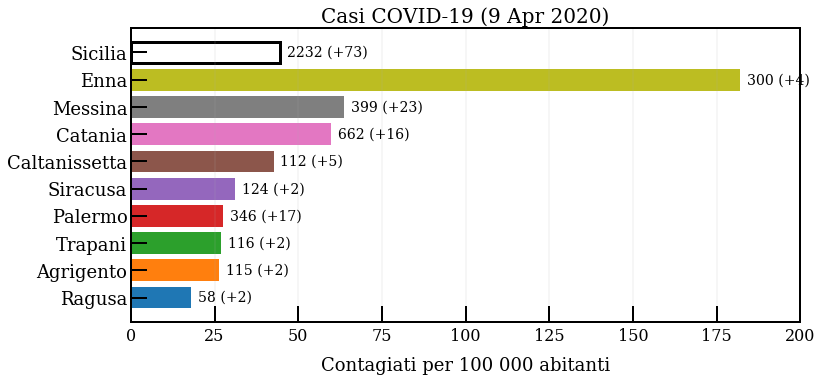

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


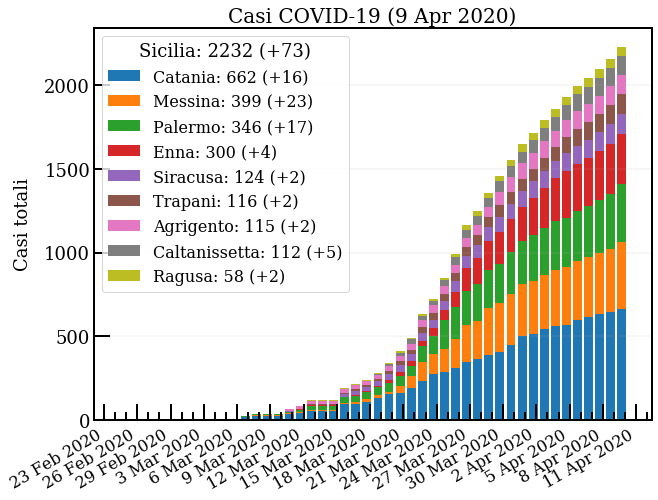

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


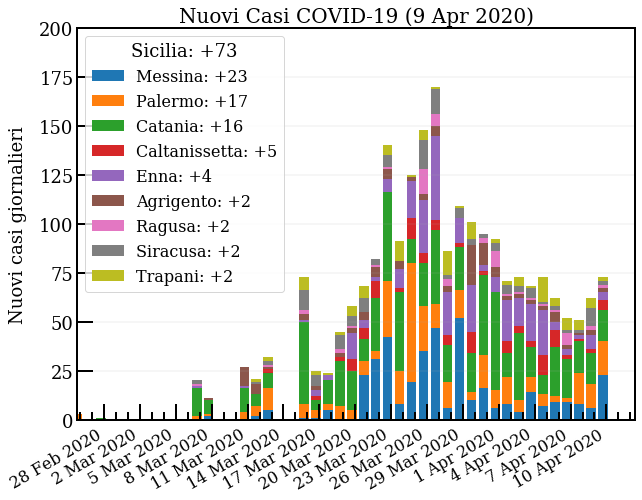

In [262]:
regione = 'Sicilia'
province = prov[prov.region==regione].provincia.unique()

standing_normalized(province, regione, 'cases', 'Casi COVID-19', 'Contagiati per 100 000 abitanti', xmax=200)

province = sorted_set_prov(prov, province, 'cases')
cumulative_stacked(province, regione, 'cases', title='Casi COVID-19', ylabel='Casi totali')

province = sorted_set_prov(prov, province, 'new_cases')
differential_stacked(province, regione, 'new_cases', 
                                  title = 'Nuovi Casi COVID-19', 
                                  ylabel = 'Nuovi casi giornalieri',
                                  ymax = 200
                                 )

# Lombardia

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


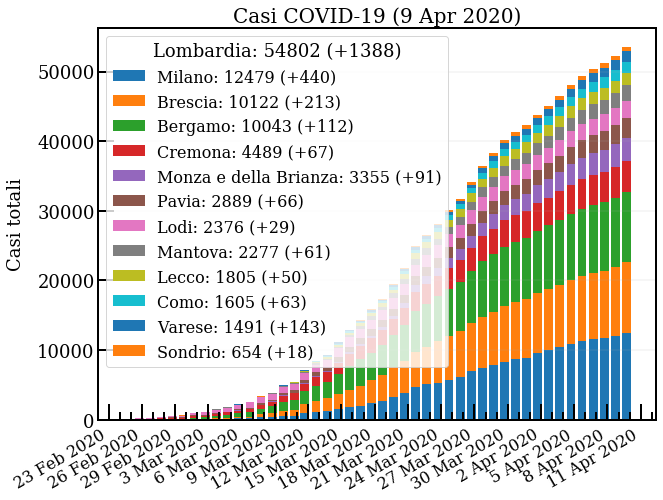

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


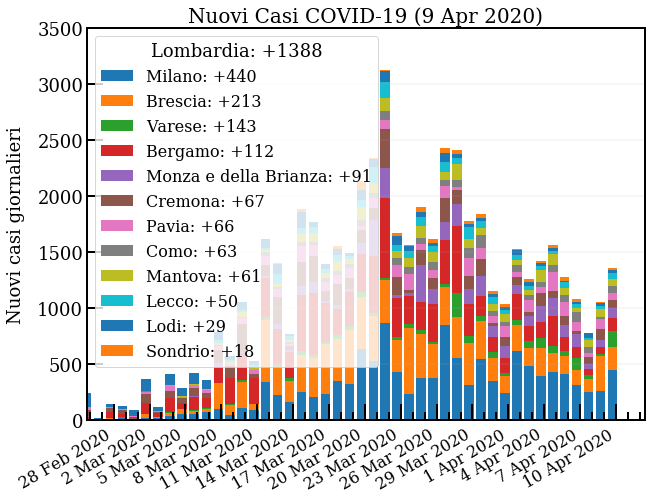

In [263]:
regione = 'Lombardia'
province = prov[prov.region==regione].provincia.unique()

# classifica casi
#standing_normalized(province, regione, 'cases', 'Casi COVID-19', 'Contagiati per 100 000 abitanti', xmax=180)

# casi totali cumulati
province = sorted_set_prov(prov, province, 'cases')
cumulative_stacked(province, regione, 'cases', title='Casi COVID-19', ylabel='Casi totali')

# nuovi casi giornalieri
province = sorted_set_prov(prov, province, 'new_cases')
differential_stacked(province, regione, 'new_cases', 
                                  title = 'Nuovi Casi COVID-19', 
                                  ylabel = 'Nuovi casi giornalieri',
                                  ymax = 3500
                                 )

# Emilia-Romagna

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


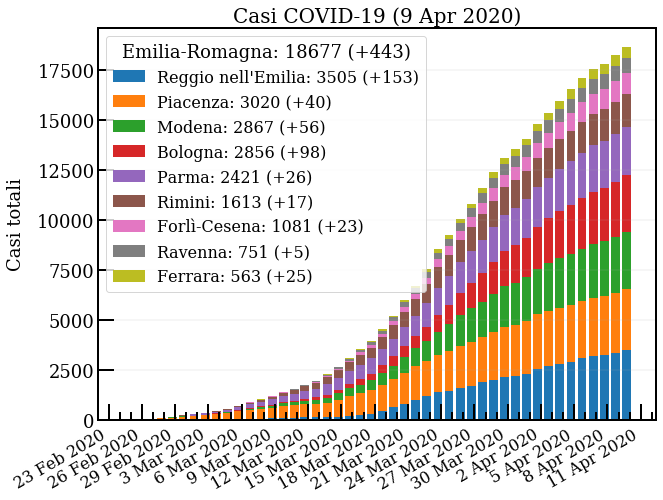

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


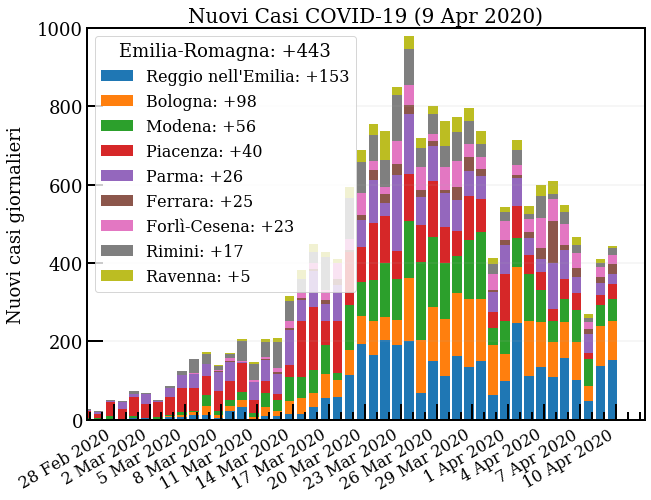

In [264]:
regione = 'Emilia-Romagna'
province = prov[prov.region==regione].provincia.unique()

# classifica casi
#standing_normalized(province, regione, 'cases', 'Casi COVID-19', 'Contagiati per 100 000 abitanti', xmax=180)

# casi totali cumulati
province = sorted_set_prov(prov, province, 'cases')
cumulative_stacked(province, regione, 'cases', title='Casi COVID-19', ylabel='Casi totali')

# nuovi casi giornalieri
province = sorted_set_prov(prov, province, 'new_cases')
differential_stacked(province, regione, 'new_cases', 
                                  title = 'Nuovi Casi COVID-19', 
                                  ylabel = 'Nuovi casi giornalieri',
                                  ymax = 1000
                                 )